Luego de todo esto ya tenemos listos todos los datos en nuestro df, el siguiente paso que procede es hacer una limpieza, esto debido a que necesitamos saber como se distribuyen los datos en cada variable del df, esto mediante 2 herramientas muy importantes y útiles que son los histogramas y los gráficos boxplot, con histogramas se nos permite de mejor forma poder ver que tipo de distribución tienen las variables independientes, estos primeros histogramas nos sirven para poder identificar valores atípicos y su tratamiento. Además, hay que tomar en cuenta que excluimos a las variables extraídas por webscraping de las comunas, esto debido a que estas son datos de instituciones gubernamentales y su fiabilidad es alta y la existencia de outliers es prácticamente imposible.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../data/interim/datos_variables_finales.csv", encoding="utf-8", delimiter=",")
df

,precio,banos,dormitorios,superficie_total,superficie_construida,estacionamiento,latitud,longitud,comuna,población 2024,...,pct_cocina_moderna,pct_propia_total,pct_arrendada,ingreso_promedio,ingreso_mediana,indice_calidad_materiales,indice_servicios_basicos,indice_calidad_vivienda_general,distancia_hospital,distancia_metro
0,322633576.0,3.0,5.0,404.0,275.0,1.0,-33.345468,-70.678398,huechuraba,101808.0,...,89.86,64.31,0.00,720051.66,402500.0,86.47,61.35,74.64,8064.787023,2554.229150
1,124089837.0,3.0,3.0,102.0,27.0,1.0,-33.563160,-70.776609,maipú,503635.0,...,92.76,70.40,0.80,601743.03,450000.0,94.91,69.46,78.23,6113.888686,6127.575990
2,157180460.0,2.0,3.0,190.0,127.0,1.0,-33.563025,-70.559425,puente alto,568086.0,...,90.62,69.71,0.18,538232.86,400000.0,93.75,65.79,78.18,845.094730,2324.734493
3,133544301.0,2.0,5.0,146.0,61.0,1.0,-33.641678,-70.689872,san bernardo,306371.0,...,90.21,58.31,1.16,488733.18,400000.0,89.94,62.44,76.41,5475.616211,11151.846959
4,117786861.0,2.0,3.0,145.0,82.0,1.0,-33.613778,-70.887450,peñaflor,94402.0,...,89.12,65.85,0.19,591753.35,400000.0,84.18,62.29,77.28,1600.028166,16662.321199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965,742425000.0,5.0,5.0,370.0,230.0,0.0,-33.421135,-70.553193,las condes,296134.0,...,98.33,56.67,0.49,1806493.23,1050000.0,97.94,92.51,77.68,4638.577959,1526.624955
5966,69709800.0,1.0,2.0,88.0,70.0,0.0,-33.513907,-70.783665,maipú,503635.0,...,92.76,70.40,0.80,601743.03,450000.0,94.91,69.46,78.23,1078.534716,2485.915755
5967,75000000.0,2.0,4.0,100.0,80.0,0.0,-33.416357,-70.765798,cerro navia,127250.0,...,94.41,61.98,1.98,446483.01,400000.0,88.17,58.32,70.63,2381.181842,3924.559734
5968,859650000.0,5.0,6.0,1000.0,320.0,0.0,-34.147102,-71.462988,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55220.407889,96236.455245


Vamos a eliminar todas las filas las cuales tengan valores nulos en la columna de comuna, esto porque son valores que no son de comunas de chile, por lo cual es data que no nos sirve, también es probable que sean datos donde no hay ni latitud ni longitud

In [3]:
df['comuna'].isnull().sum()

np.int64(20)

Por lo que en cualquiera de los 2 casos, no se nos es posible imputar esta data

In [4]:
df = df.dropna(subset=['comuna'])

Aquí vemos que los valores nulos y valores no numéricos que hay incluyendo y despueés de la columna comuna, esto lo hago para verificar si las variables agregadas requieren algún tipo de tratamiento, pero solo requerimos de una estrategia de limpieza para las variables estructurales como precio, superficie total, superficie construida, dormitorios, etc... Y no tanto geográficas

In [5]:
cols_desde_comuna = df.columns[df.columns.get_loc('comuna'):]
cols_despues_comuna = df.columns[df.columns.get_loc('comuna') + 1 :]
nulos_desde_comuna = df[cols_desde_comuna].isnull().sum()[df[cols_desde_comuna].isnull().sum() > 0]
non_numeric_mask = df[cols_despues_comuna].apply(lambda col: pd.to_numeric(col, errors='coerce').isna() & col.notna())
non_numeric_counts = non_numeric_mask.sum()
no_numericos = non_numeric_counts[non_numeric_counts > 0]

print("🔹 Valores nulos desde 'comuna':")
print(nulos_desde_comuna)
print("\n🔹 Valores no numéricos después de 'comuna':")
print(no_numericos)


🔹 Valores nulos desde 'comuna':
Series([], dtype: int64)

🔹 Valores no numéricos después de 'comuna':
Series([], dtype: int64)


Aquí eliminamos las filas con 3 o más valores nulos

In [6]:
variables_criticas = [
    'precio', 'banos', 'dormitorios', 'superficie_total', 
    'superficie_construida', 'estacionamiento', 'latitud', 
    'longitud', 'comuna'
]

filas_originales = len(df)
nulos_por_fila = df[variables_criticas].isnull().sum(axis=1)
filas_eliminar = nulos_por_fila >= 3
df = df[~filas_eliminar].copy()
filas_eliminadas = filas_originales - len(df)
print(f"Filas eliminadas: {filas_eliminadas:,} ({filas_eliminadas/filas_originales*100:.2f}%)")


Filas eliminadas: 7 (0.12%)


Con los histogramas podemos identificar la forma de distribución de las variables, obviamente como no le hemos hecho una limpieza, hay algunas variables que no se puede ver bien la forma de distribución, pero nos ayuda a ver por qué magnitudes están los outliers

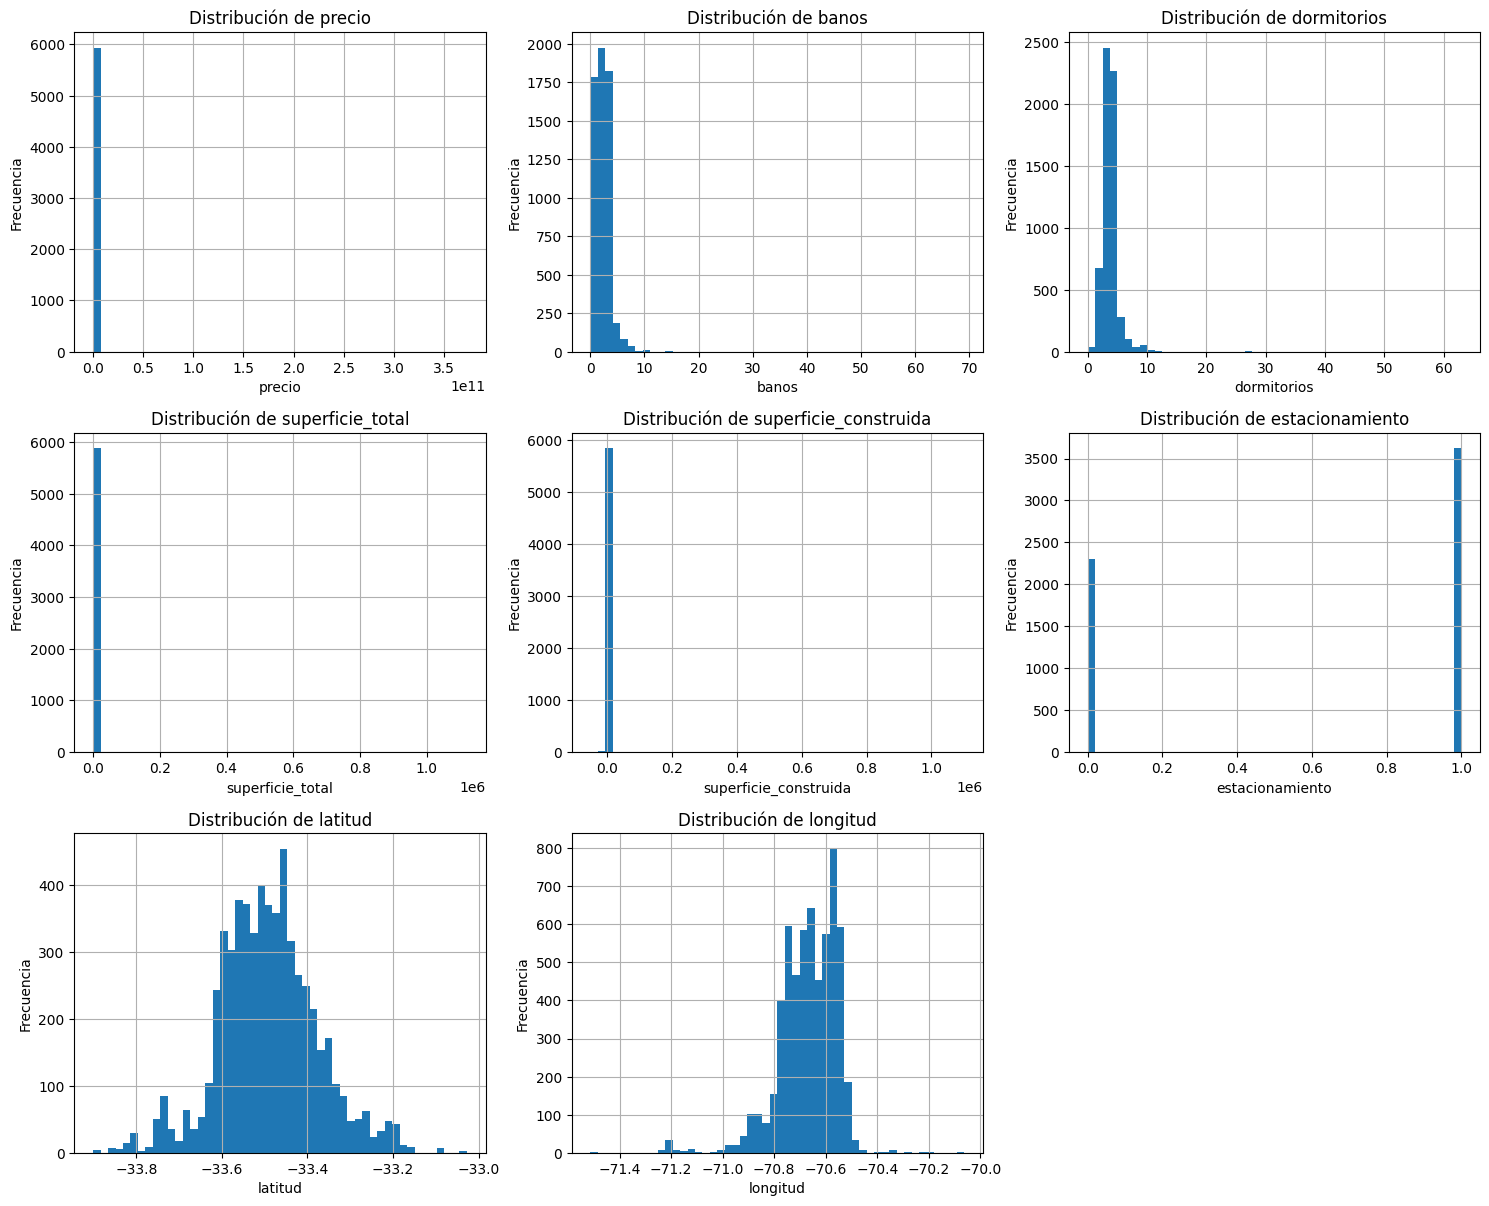

In [ ]:
numeric_cols = df.select_dtypes(include='number').columns
n_cols = 3 
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:8]):
    df[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Los gráficos boxplot nos dan otra cara de la moneda de las variables, los gráficos boxplot nos ayudan a identificar los valores atípicos que tiene cada variable

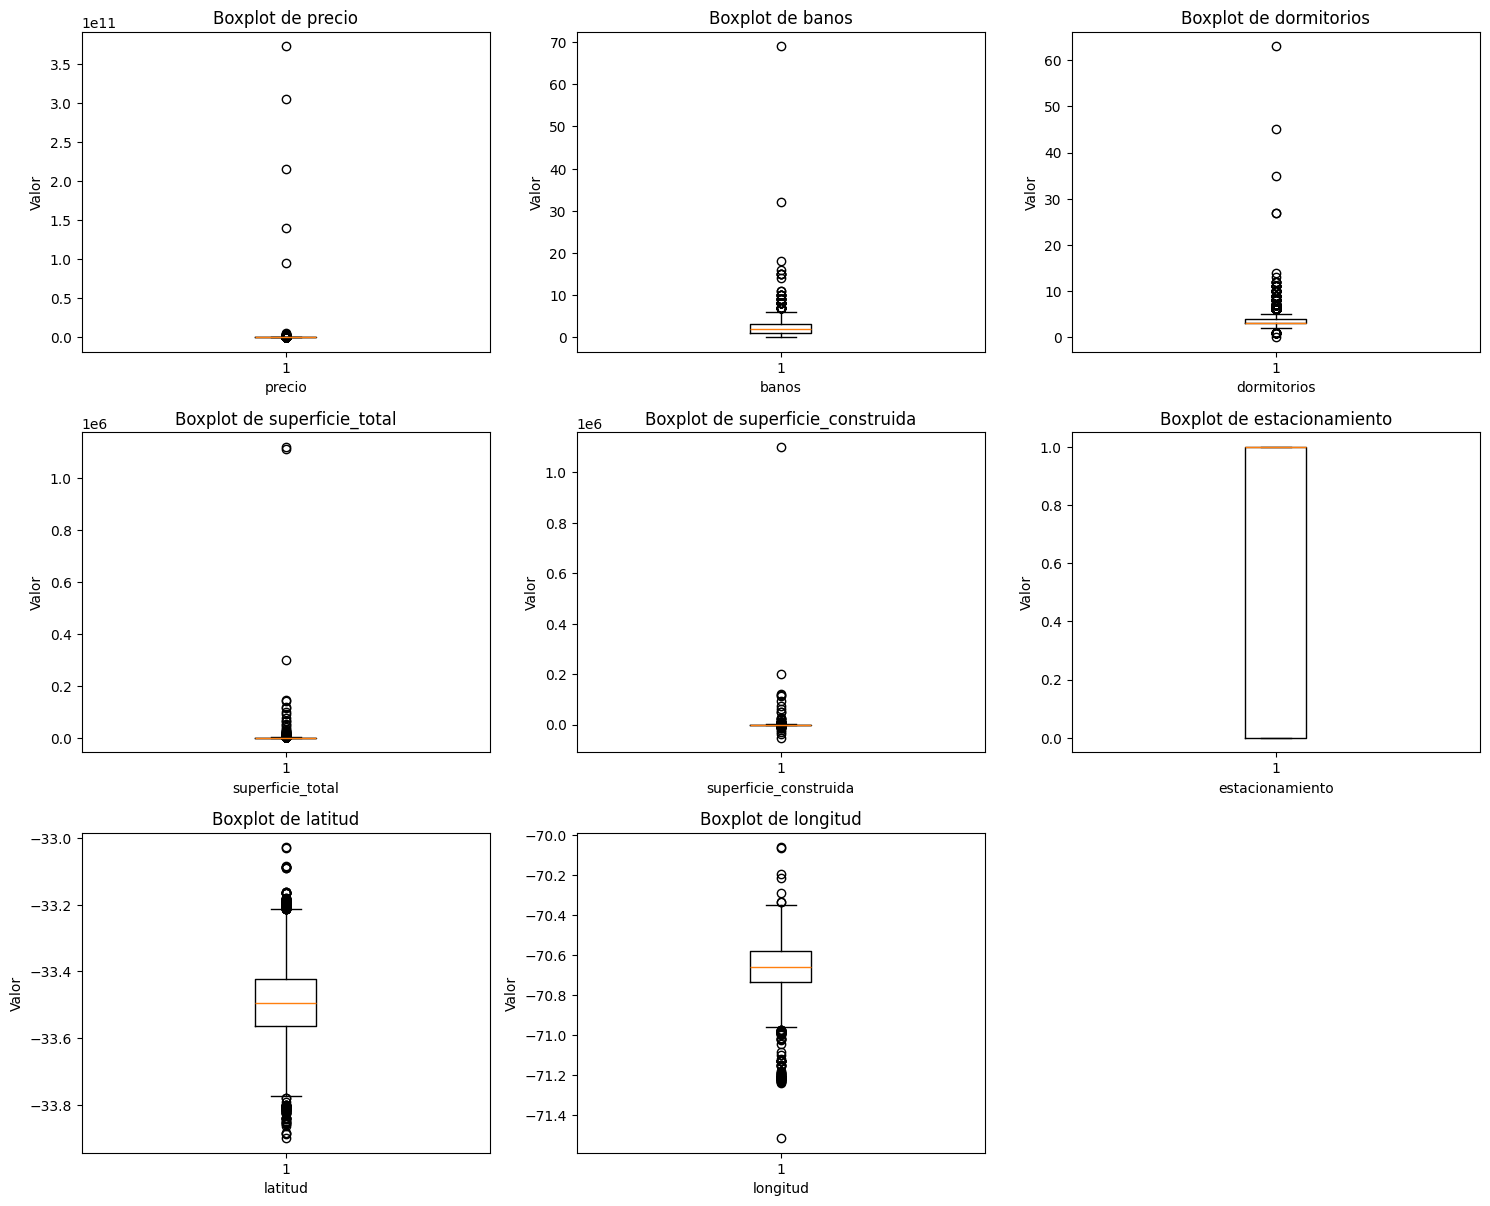

In [8]:
numeric_cols = df.select_dtypes(include='number').columns
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:8]):
    axes[i].boxplot(df[col].dropna(), vert=True)
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Valor')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Gracias a los boxplots e histogramas, podemos printear la cantidad de valores que estan por arriba, por debajo, y entre medio de ciertos limites como se puede observar en la celda de abajo, cabe recalcar que este es un proceso iterativo, y de ánalisis profundo en el comportamiento del fénomeno de estudio para decidir que método de limpieza se va a utilizar

In [9]:
precio_bajo = df[df['precio'] < 30000000] 
print(f"Registros con precio < 30M CLP: {len(precio_bajo)}")
precio_alto = df[df['precio'] > 900000000] 
print(f"Registros con precio >900M CLP: {len(precio_alto)}")
superficie_cero = df[df['superficie_total'] <= 60]  
print(f"Registros con superficie_total ≤ 60 m²: {len(superficie_cero)}")
superficie_alta = df[df['superficie_total'] > 1000]  
print(f"Registros con superficie_total > 1000 m²: {len(superficie_alta)}")
superficie_construida_baja = df[df['superficie_construida'] <= 40]  
print(f"Registros con superficie_construida ≤ 40 m²: {len(superficie_construida_baja)}")
superficie_construida_alta = df[df['superficie_construida'] > 1000] 
print(f"Registros con superficie_construida > 1000 m²: {len(superficie_construida_alta)}")
sin_dormitorios = df[(df['dormitorios'] == 0)]
print(f"Registros con 0 dormitorios: {len(sin_dormitorios)}")
sin_banos = df[(df['banos'] == 0)]
print(f"Registros con 0 baños: {len(sin_banos)}")
banos_altos = df[(df['banos'] > 10)]
print(f"Registros con 10 baños o más: {len(banos_altos)}")

Registros con precio < 30M CLP: 41
Registros con precio >900M CLP: 179
Registros con superficie_total ≤ 60 m²: 159
Registros con superficie_total > 1000 m²: 392
Registros con superficie_construida ≤ 40 m²: 544
Registros con superficie_construida > 1000 m²: 110
Registros con 0 dormitorios: 1
Registros con 0 baños: 2
Registros con 10 baños o más: 11


Luego de ver la frecuencia de datos dentro de ciertos intervalos, tomamos la decisión de borrarlos, hay varios outliers que o por error de tipeo no nos sirven en el dataset, como los precios demasiado altos, que se comportan de forma distinta, como casas con precios mayores a 900 millones de pesos, que tienen atributos distintos y capturan un comportamiento y fénomeno distinto al que yo quiero predecir, como casas con grandes terrenos y con cultivos, piscinas, huertos, etc... por lo que en este caso específico se precindira de ellos

In [10]:
len(df)

5943

In [11]:
df = df[
    (df['precio'] > 30000000) &          
    (df['precio'] < 900000000) &        
    (df['superficie_total'] < 1000) & 
    (df['superficie_total'] > 60) & 
    (df['dormitorios'] >= 1) & 
    (df['superficie_construida'] < 1000) &   
    (df['superficie_construida'] > 40) &
    (df['banos'] < 10) & 
    (df['banos'] > 0) 
]

In [12]:
len(df)

4733

In [13]:
print(f"Filas antes de eliminar duplicados: {len(df)}")
df = df.drop_duplicates()
print(f"Filas después de eliminar duplicados: {len(df)}")

Filas antes de eliminar duplicados: 4733
Filas después de eliminar duplicados: 4525


In [14]:
print(df.columns.tolist())

['precio', 'banos', 'dormitorios', 'superficie_total', 'superficie_construida', 'estacionamiento', 'latitud', 'longitud', 'comuna', 'población 2024', 'índice masculinidad 2024', 'grupo_etario_0_a_14_2024_(%)', 'grupo_etario_15_a_29_2024_(%)', 'grupo_etario_30_a_44_2024_(%)', 'grupo_etario_45_a_64_2024_(%)', 'grupo_etario_65_o_mas_2024_(%)', 'idd 2024', 'iam 2024', 'pobreza por ingresos 2022 (%)', 'pobreza multidimensional 2022 (%)', 'pueblos indígenas 2025 (%)', 'extranjeros 2025 (%)', 'carentes servicios básicos 2025 (%)', 'hogares hacinados 2025 (%)', 'cantidad de: atención remota 2025', 'cantidad de: centro comunitario de salud familiar (cecosf) 2025', 'cantidad de: centro comunitario de salud mental  (cosam) 2025', 'cantidad de: centro corporación para la nutrición infantil (conin) 2025', 'cantidad de: centro de apoyo comunitario para personas con demencia 2025', 'cantidad de: centro diagnóstico terapéutico y tratamiento privado (cdt) 2025', 'cantidad de: centro de diálisis 2025', 

Luego de una limpieza de cada variable, podemos volver a visualizar con histogramas y boxplots el comportamiento de cada una de las variables, y con ello poder identificar que forma de distribución tienen las variables y si es que es necesario ser más agresivos con el data cleaning o si se requiere tomar un enfoque más conservador

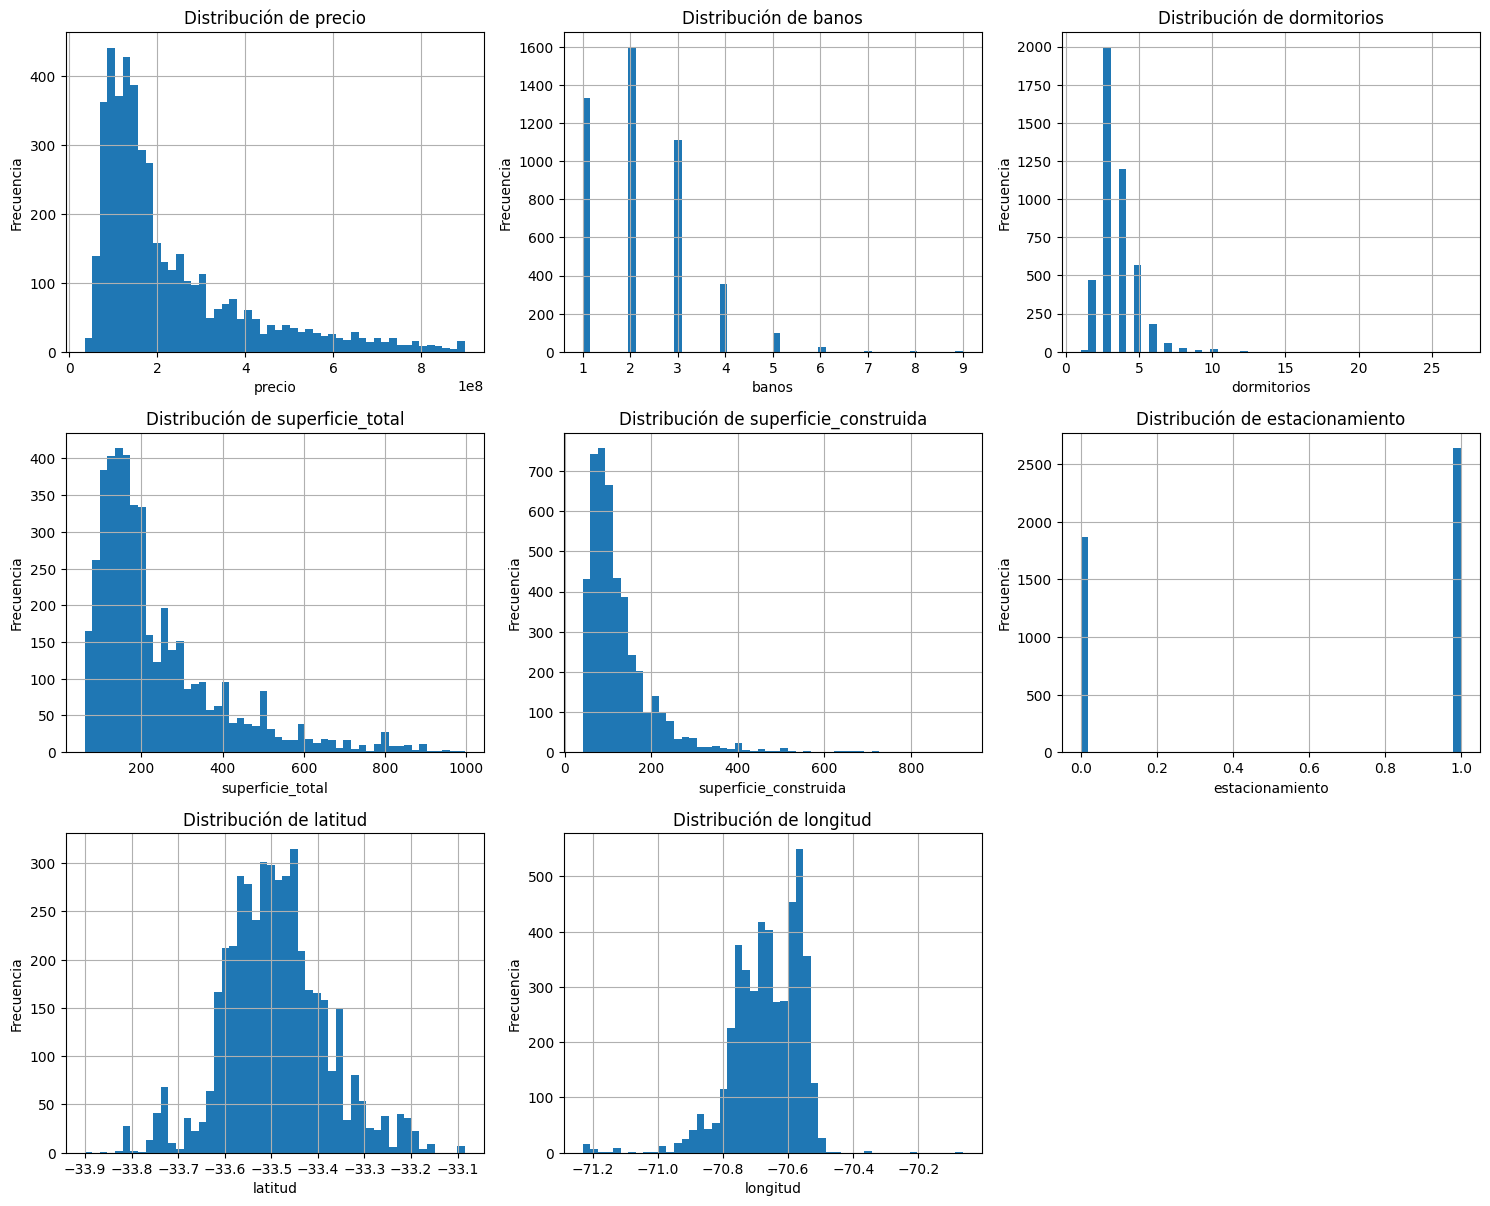

In [15]:
numeric_cols = df.select_dtypes(include='number').columns
n_cols = 3 
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:8]):
    df[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Ahora podemos ver un mejor comportamiento de los gráficos boxplots al eliminar outliers, y aunque todavía quedan algunos valores que caen lejos de los rangos definidos por los cuartiles, siguen siendo útiles y beneficiosos para el modelo, ya que estos representan la forma sesgada de la variable

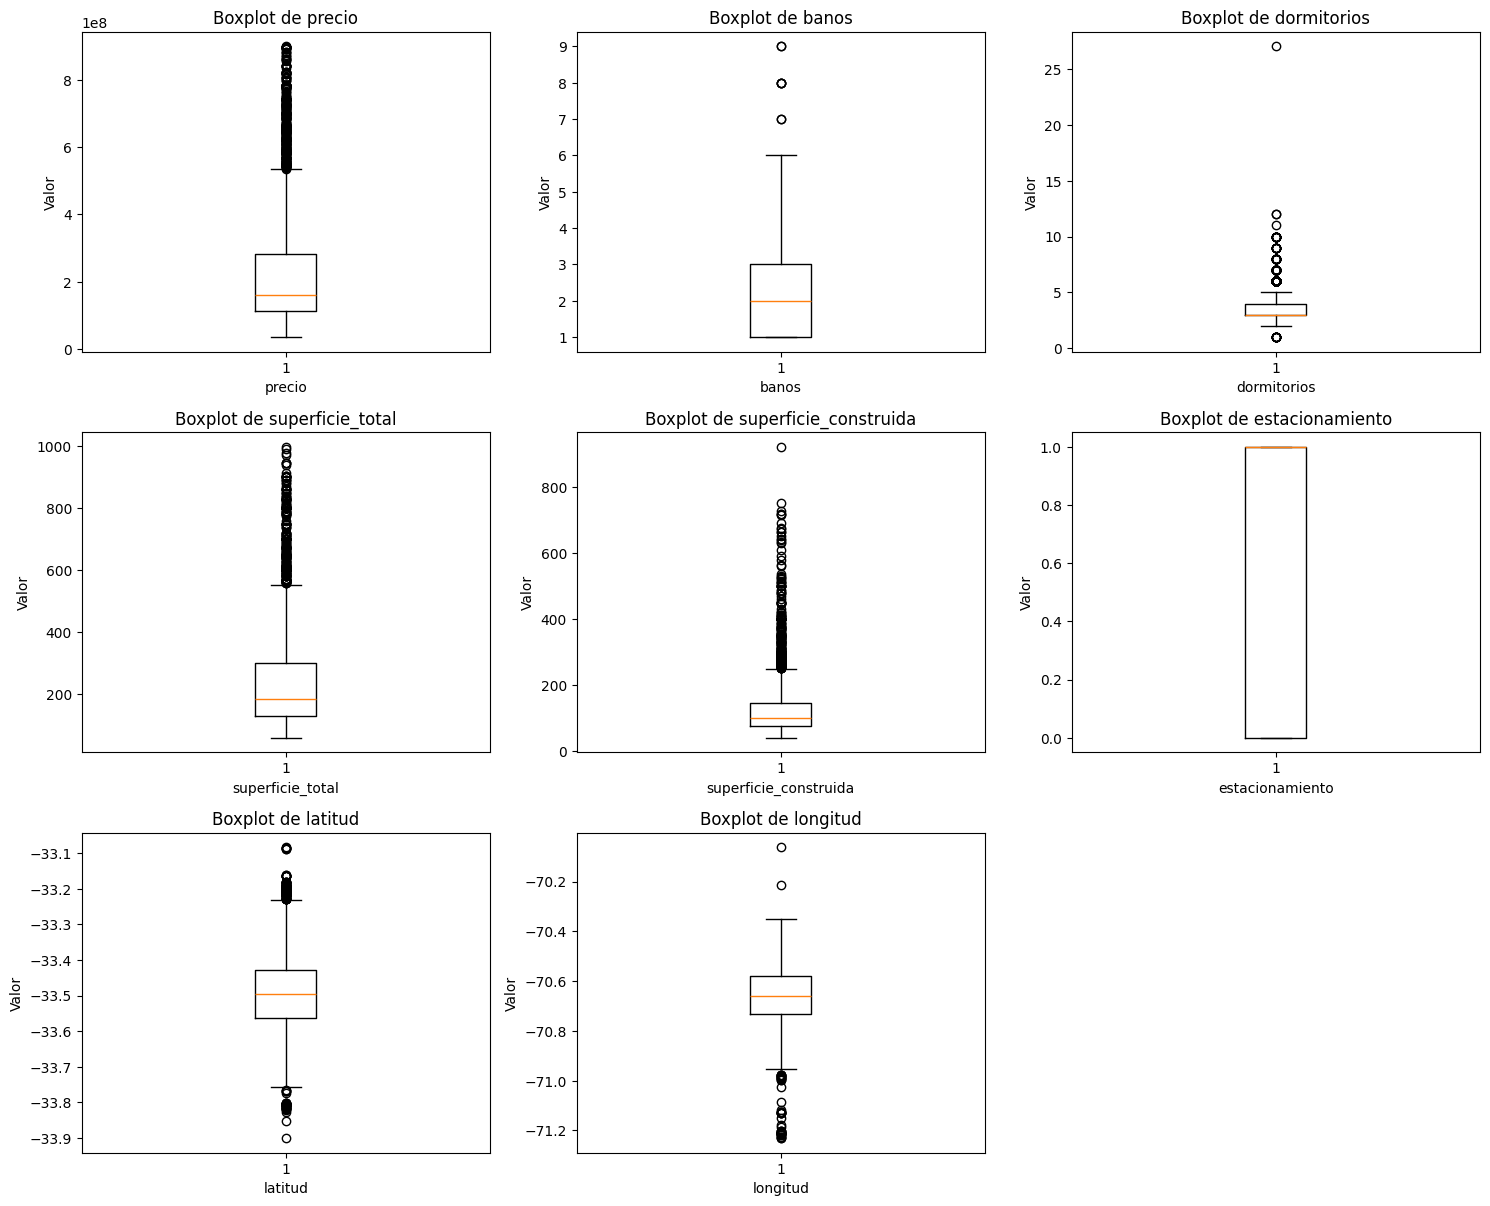

In [16]:
numeric_cols = df.select_dtypes(include='number').columns
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:8]):
    axes[i].boxplot(df[col].dropna(), vert=True)
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Valor')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [17]:
df.isnull().sum(axis=1).sum()

np.int64(17)

In [18]:
df.to_csv("../../data/processed/data_final.csv", index=False)

Para poder trabajar correctamente con la columna de 'comuna' se requiere usar herramientas de encoding, esto debido a que random forest, xgboost y lgbm no pueden trabajar con strings(palabras), por lo que se requiere que se transformen a números, hay varios tipos de encoding, one-hot encoding, label encoding, o embedding, el que voy a usar es el label-encoding, el cual le asigna una secuencia de números a las categorías únicas de la variable, por ejemplo Alhué es 1 Buin 2 y así sucesivamente

In [ ]:
le = LabelEncoder()
df['comuna'] = le.fit_transform(df['comuna'])

In [20]:
df = df.dropna()